In [33]:
import os
import shutil 
from tqdm import tqdm
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models

# Data

In [42]:
train_dir = '/content/drive/My Drive/data/train'
val_dir = '/content/drive/My Drive/data/val'

# transformation, augmentation, normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

# transformation, normalization
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 50
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

Since I don't have a GPU:
1.  I trained the network in google colab
2.  used only 2000 training images, which probably affected the validation accuracy

In [40]:
len(train_dataset), len(train_dataloader)

(2000, 40)

In [41]:
len(val_dataset), len(val_dataloader)

(1000, 20)

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


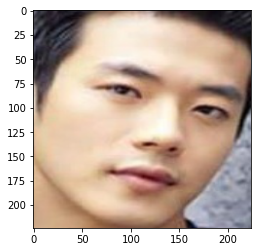

In [39]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

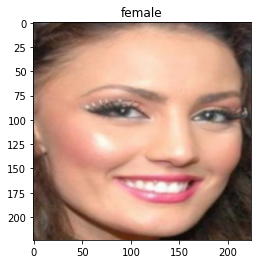

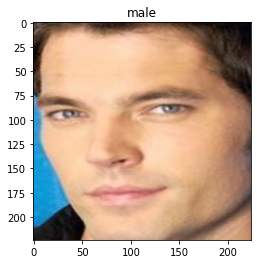

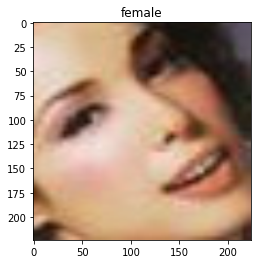

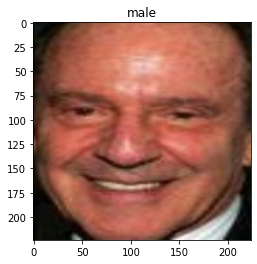

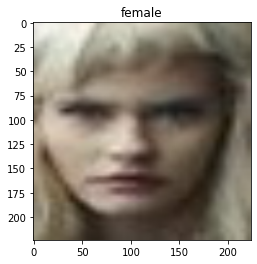

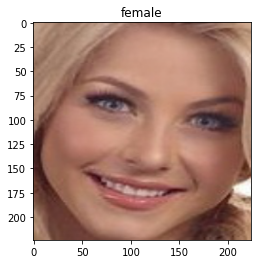

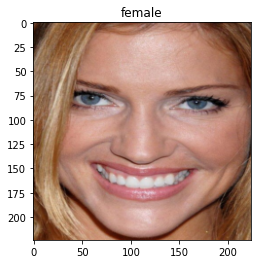

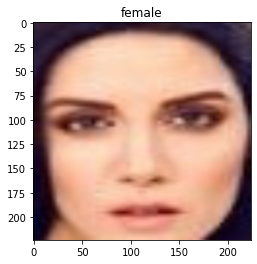

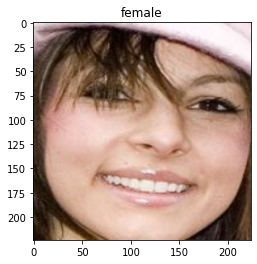

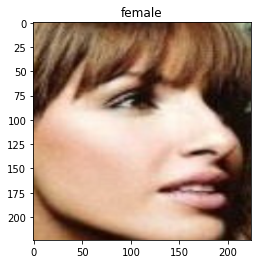

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

# Model (ResNet18), Optimizer, Scheduler

In [56]:
model = models.resnet18(pretrained=True)

# disable grad for all conv layers
for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# decay LR by a factor of 0.1 every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train model

In [57]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    accuracy_train_history = []
    accuracy_val_history = []
    loss_train_history = []
    loss_val_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # iterate over data
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
   

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
              loss_train_history.append(epoch_loss)
              accuracy_train_history.append(epoch_acc)
            elif phase == 'val':
              loss_val_history.append(epoch_loss)
              accuracy_val_history.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    # statistics visualization
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(loss_val_history, label='loss_val')
    axes[0].plot(loss_train_history, label='loss_train')
    axes[0].set(xlabel='Epoch', ylabel='Loss')
    axes[0].legend()
    axes[1].plot(accuracy_val_history, label='acc_val')
    axes[1].plot(accuracy_train_history, label='acc_train')
    axes[1].set(xlabel='Epoch', ylabel='Accuracy')
    axes[1].legend()
    plt.show()

    return model

# Training and results

Epoch 0/49:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.6121 Acc: 0.6725



100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

val Loss: 0.4794 Acc: 0.8070
Epoch 1/49:



100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.4234 Acc: 0.8360



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.3878 Acc: 0.8530
Epoch 2/49:



100%|██████████| 40/40 [00:12<00:00,  3.11it/s]

train Loss: 0.3701 Acc: 0.8475



100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

val Loss: 0.3871 Acc: 0.8210
Epoch 3/49:



100%|██████████| 40/40 [00:12<00:00,  3.08it/s]

train Loss: 0.3438 Acc: 0.8520



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.3379 Acc: 0.8630
Epoch 4/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.3325 Acc: 0.8620



100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

val Loss: 0.3641 Acc: 0.8370
Epoch 5/49:



100%|██████████| 40/40 [00:12<00:00,  3.11it/s]

train Loss: 0.3272 Acc: 0.8615



100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

val Loss: 0.3298 Acc: 0.8470
Epoch 6/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2958 Acc: 0.8745



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.3125 Acc: 0.8730
Epoch 7/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2840 Acc: 0.8845



100%|██████████| 20/20 [00:07<00:00,  2.55it/s]

val Loss: 0.3071 Acc: 0.8760
Epoch 8/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2835 Acc: 0.8795



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.3078 Acc: 0.8700
Epoch 9/49:



100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.2768 Acc: 0.8860



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.3019 Acc: 0.8750
Epoch 10/49:



100%|██████████| 40/40 [00:12<00:00,  3.11it/s]

train Loss: 0.2749 Acc: 0.8840



100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

val Loss: 0.3009 Acc: 0.8760
Epoch 11/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2755 Acc: 0.8905



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.3011 Acc: 0.8750
Epoch 12/49:



100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.2780 Acc: 0.8890



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.3009 Acc: 0.8730
Epoch 13/49:



100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.2690 Acc: 0.8950



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2986 Acc: 0.8770
Epoch 14/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2646 Acc: 0.8940



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.3027 Acc: 0.8760
Epoch 15/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2639 Acc: 0.8955



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.2998 Acc: 0.8760
Epoch 16/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2600 Acc: 0.8935



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2998 Acc: 0.8730
Epoch 17/49:



100%|██████████| 40/40 [00:12<00:00,  3.09it/s]

train Loss: 0.2628 Acc: 0.9010



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.3004 Acc: 0.8700
Epoch 18/49:



100%|██████████| 40/40 [00:13<00:00,  3.08it/s]

train Loss: 0.2668 Acc: 0.8980



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2989 Acc: 0.8770
Epoch 19/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2585 Acc: 0.8950



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2989 Acc: 0.8790
Epoch 20/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2637 Acc: 0.8965



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.3002 Acc: 0.8780
Epoch 21/49:



100%|██████████| 40/40 [00:12<00:00,  3.08it/s]

train Loss: 0.2642 Acc: 0.8995



100%|██████████| 20/20 [00:07<00:00,  2.61it/s]

val Loss: 0.2986 Acc: 0.8770
Epoch 22/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2639 Acc: 0.8950



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2981 Acc: 0.8750
Epoch 23/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2666 Acc: 0.8985



100%|██████████| 20/20 [00:07<00:00,  2.55it/s]

val Loss: 0.3000 Acc: 0.8740
Epoch 24/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2649 Acc: 0.8900



100%|██████████| 20/20 [00:08<00:00,  2.40it/s]

val Loss: 0.3007 Acc: 0.8750
Epoch 25/49:



100%|██████████| 40/40 [00:12<00:00,  3.11it/s]

train Loss: 0.2635 Acc: 0.8910



100%|██████████| 20/20 [00:07<00:00,  2.55it/s]

val Loss: 0.2998 Acc: 0.8760
Epoch 26/49:



100%|██████████| 40/40 [00:12<00:00,  3.17it/s]

train Loss: 0.2547 Acc: 0.9045



100%|██████████| 20/20 [00:07<00:00,  2.67it/s]

val Loss: 0.2990 Acc: 0.8740
Epoch 27/49:



100%|██████████| 40/40 [00:12<00:00,  3.17it/s]

train Loss: 0.2657 Acc: 0.8970



100%|██████████| 20/20 [00:07<00:00,  2.72it/s]

val Loss: 0.2985 Acc: 0.8740
Epoch 28/49:



100%|██████████| 40/40 [00:12<00:00,  3.14it/s]

train Loss: 0.2668 Acc: 0.8880



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2982 Acc: 0.8770
Epoch 29/49:



100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

train Loss: 0.2569 Acc: 0.8985



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2986 Acc: 0.8760
Epoch 30/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2693 Acc: 0.8925



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2976 Acc: 0.8740
Epoch 31/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2622 Acc: 0.8995



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2996 Acc: 0.8770
Epoch 32/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2575 Acc: 0.9030



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2994 Acc: 0.8760
Epoch 33/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2632 Acc: 0.8945



100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

val Loss: 0.2975 Acc: 0.8770
Epoch 34/49:



100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

train Loss: 0.2679 Acc: 0.8865



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2979 Acc: 0.8750
Epoch 35/49:



100%|██████████| 40/40 [00:13<00:00,  3.04it/s]

train Loss: 0.2614 Acc: 0.8975



100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

val Loss: 0.2982 Acc: 0.8740
Epoch 36/49:



100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

train Loss: 0.2677 Acc: 0.8955



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2974 Acc: 0.8770
Epoch 37/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2657 Acc: 0.8955



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.3003 Acc: 0.8770
Epoch 38/49:



100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

train Loss: 0.2625 Acc: 0.8925



100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

val Loss: 0.2982 Acc: 0.8760
Epoch 39/49:



100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

train Loss: 0.2681 Acc: 0.8860



100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

val Loss: 0.2976 Acc: 0.8740
Epoch 40/49:



100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

train Loss: 0.2640 Acc: 0.8980



100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

val Loss: 0.2984 Acc: 0.8750
Epoch 41/49:



100%|██████████| 40/40 [00:13<00:00,  3.04it/s]

train Loss: 0.2730 Acc: 0.8890



100%|██████████| 20/20 [00:07<00:00,  2.61it/s]

val Loss: 0.3004 Acc: 0.8760
Epoch 42/49:



100%|██████████| 40/40 [00:12<00:00,  3.08it/s]

train Loss: 0.2729 Acc: 0.8960



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.3001 Acc: 0.8760
Epoch 43/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2683 Acc: 0.8940



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2984 Acc: 0.8770
Epoch 44/49:



100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

train Loss: 0.2593 Acc: 0.9000



100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

val Loss: 0.2994 Acc: 0.8780
Epoch 45/49:



100%|██████████| 40/40 [00:13<00:00,  3.03it/s]

train Loss: 0.2585 Acc: 0.8985



100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.2980 Acc: 0.8780
Epoch 46/49:



100%|██████████| 40/40 [00:13<00:00,  3.03it/s]

train Loss: 0.2772 Acc: 0.8855



100%|██████████| 20/20 [00:07<00:00,  2.56it/s]

val Loss: 0.2995 Acc: 0.8780
Epoch 47/49:



100%|██████████| 40/40 [00:13<00:00,  3.03it/s]

train Loss: 0.2739 Acc: 0.8865



100%|██████████| 20/20 [00:07<00:00,  2.56it/s]

val Loss: 0.2982 Acc: 0.8740
Epoch 48/49:



100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

train Loss: 0.2667 Acc: 0.8925



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.2992 Acc: 0.8780
Epoch 49/49:



100%|██████████| 40/40 [00:13<00:00,  3.04it/s]

train Loss: 0.2616 Acc: 0.8955



100%|██████████| 20/20 [00:07<00:00,  2.57it/s]

val Loss: 0.3000 Acc: 0.8740


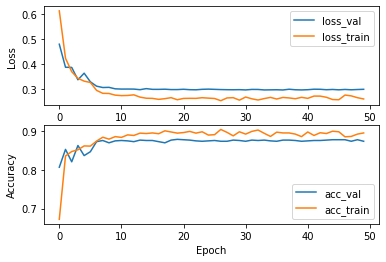

In [58]:
train_model(model, loss, optimizer, scheduler, num_epochs=50);

# Saving model

In [59]:
torch.save(model.cpu(), 'model_trained.pt')